## * Imports & Config

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, InceptionV3, Xception


2025-12-17 14:52:47.159656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765983167.319149      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765983167.363753      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765983167.754339      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765983167.754382      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765983167.754385      24 computation_placer.cc:177] computation placer alr

## Configuration

In [2]:
DATA_DIR = "/kaggle/input/fake-news-detection-bilingual-multimodel-fusion/news_dataset/for_image"
IMG_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 20

MODEL_NAME = "custom_cnn"
# options:
# "custom_cnn"
# "mobilenet"
# "inception"
# "xception"


## Load Dataset

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

class_names = dataset.class_names
print("Classes:", class_names)

Found 9936 files belonging to 2 classes.


I0000 00:00:1765983188.435960      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Classes: ['fake', 'real']


## Preprocessing

In [4]:
def normalize_data(data):
    return data.map(lambda x, y: (x / 255.0, y))

def split_data(data, train_ratio=0.7, val_ratio=0.15):
    total = len(data)

    train_size = int(total * train_ratio)
    val_size = int(total * val_ratio)

    train = data.take(train_size)
    val = data.skip(train_size).take(val_size)
    test = data.skip(train_size + val_size)

    return train, val, test

def optimize_pipeline(ds):
    return ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


# Apply preprocessing
dataset = normalize_data(dataset)
train, val, test = split_data(dataset)

train = optimize_pipeline(train)
val = optimize_pipeline(val)
test = optimize_pipeline(test)


In [5]:
print("Total batches:", len(dataset))
print("Train batches:", len(train))
print("Validation batches:", len(val))
print("Test batches:", len(test))

Total batches: 311
Train batches: 217
Validation batches: 46
Test batches: 48


## All CNN based Models

In [6]:
def get_model(model_name, input_shape=(256,256,3)):
    
    if model_name == "custom_cnn":
        model = Sequential([
            Conv2D(32,3,activation='relu', input_shape=input_shape),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(64,3,activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Conv2D(128,3,activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),

            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

    elif model_name == "mobilenet":
        base = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)
        base.trainable = False
        x = GlobalAveragePooling2D()(base.output)
        out = Dense(1, activation="sigmoid")(x)
        model = Model(base.input, out)

    elif model_name == "inception":
        base = InceptionV3(weights="imagenet", include_top=False, input_shape=input_shape)
        base.trainable = False
        x = GlobalAveragePooling2D()(base.output)
        out = Dense(1, activation="sigmoid")(x)
        model = Model(base.input, out)

    elif model_name == "xception":
        base = Xception(weights="imagenet", include_top=False, input_shape=input_shape)
        base.trainable = False
        x = GlobalAveragePooling2D()(base.output)
        out = Dense(1, activation="sigmoid")(x)
        model = Model(base.input, out)

    else:
        raise ValueError("Unknown model")

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    return model


## Evaluation Function

In [7]:
def evaluate_model(model, test, model_name, plot_cm=True):
    y_true, y_pred = [], []

    for x, y in test:
        preds = model.predict(x, verbose=0)
        preds = (preds > 0.5).astype(int)

        y_true.extend(y.numpy())
        y_pred.extend(preds.flatten())

    # Metrics
    acc = accuracy_score(y_true, y_pred)

    p_macro, r_macro, f_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )
    p_micro, r_micro, f_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro"
    )
    p_weighted, r_weighted, f_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )

    # Print results
    print(f"\n===== Evaluation Results: {model_name} =====")
    print(f"Accuracy            : {acc:.4f}")
    print("\nMacro Average")
    print(f"  Precision         : {p_macro:.4f}")
    print(f"  Recall            : {r_macro:.4f}")
    print(f"  F1-score          : {f_macro:.4f}")

    print("\nMicro Average")
    print(f"  Precision         : {p_micro:.4f}")
    print(f"  Recall            : {r_micro:.4f}")
    print(f"  F1-score          : {f_micro:.4f}")

    print("\nWeighted Average")
    print(f"  Precision         : {p_weighted:.4f}")
    print(f"  Recall            : {r_weighted:.4f}")
    print(f"  F1-score          : {f_weighted:.4f}")
    print("=" * 40)

    # Confusion Matrix
    if plot_cm:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(model_name)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision (Macro)": p_macro,
        "Recall (Macro)": r_macro,
        "F1 (Macro)": f_macro,
        "Precision (Micro)": p_micro,
        "Recall (Micro)": r_micro,
        "F1 (Micro)": f_micro,
        "Precision (Weighted)": p_weighted,
        "Recall (Weighted)": r_weighted,
        "F1 (Weighted)": f_weighted
    }

## Offline Tracking

In [8]:
import os
import json
from tensorflow.keras.models import save_model

LOG_DIR = "/kaggle/working/mlruns"  # offline "mlflow" directory
os.makedirs(LOG_DIR, exist_ok=True)

def log_offline(
    model,
    model_name,
    metrics,
    history,
    epochs,
    batch_size,
    img_size,
    model_path
):
    """
    Logs model, parameters, metrics, and training history offline.
    """
    run_dir = os.path.join(LOG_DIR, model_name)
    os.makedirs(run_dir, exist_ok=True)

    # Save parameters
    params = {
        "model": model_name,
        "epochs": epochs,
        "batch_size": batch_size,
        "image_size": img_size,
        "saved_model_path": model_path
    }
    with open(os.path.join(run_dir, "params.json"), "w") as f:
        json.dump(params, f, indent=4)

    # Save metrics
    metrics_to_save = {
        "test_accuracy": metrics["Accuracy"],
        "test_f1_micro": metrics["F1 (Micro)"],
        "test_f1_macro": metrics["F1 (Macro)"],
        "test_f1_weighted": metrics["F1 (Weighted)"],
        "best_val_accuracy": max(history.history["val_accuracy"])
    }
    with open(os.path.join(run_dir, "metrics.json"), "w") as f:
        json.dump(metrics_to_save, f, indent=4)

    # Save training history
    with open(os.path.join(run_dir, "history.json"), "w") as f:
        json.dump(history.history, f, indent=4)

    # Save model
    save_model(model, model_path)
    print(f"✅ Run logged offline at {run_dir}")


In [9]:
def save_trained_model(model, model_name):
    save_dir = "/kaggle/working/saved_models"
    os.makedirs(save_dir, exist_ok=True)

    model_path = os.path.join(save_dir, f"{model_name}.keras")
    model.save(model_path)

    print(f"✅ Model saved to: {model_path}")
    return model_path

## Comparison Table

In [10]:
def update_comparison_table(metrics, model_name):
    row = {
        "Model": model_name,
        "Accuracy": metrics["Accuracy"],
        "F1 Micro": metrics["F1 (Micro)"],
        "F1 Macro": metrics["F1 (Macro)"],
        "F1 Weighted": metrics["F1 (Weighted)"],
    }

    path = "/kaggle/working/model_comparison.csv"

    if os.path.exists(path):
        df = pd.read_csv(path)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(path, index=False)
    return df

## Tranining(Custom CNN)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


I0000 00:00:1765983193.456089      70 service.cc:152] XLA service 0x79f844002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765983193.456132      70 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765983194.229177      70 cuda_dnn.cc:529] Loaded cuDNN version 91002


  2/217 ━━━━━━━━━━━━━━━━━━━━ 31s 148ms/step - accuracy: 0.5078 - loss: 8.1516

I0000 00:00:1765983199.710738      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 ━━━━━━━━━━━━━━━━━━━━ 57s 222ms/step - accuracy: 0.7040 - loss: 2.3907 - val_accuracy: 0.4871 - val_loss: 1.0614
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8037 - loss: 0.3671 - val_accuracy: 0.5958 - val_loss: 1.9572
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8349 - loss: 0.3532 - val_accuracy: 0.9171 - val_loss: 0.1843
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.8872 - loss: 0.2300 - val_accuracy: 0.9300 - val_loss: 0.1476
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9039 - loss: 0.1989 - val_accuracy: 0.9293 - val_loss: 0.1815
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9159 - loss: 0.1569 - val_accuracy: 0.9389 - val_loss: 0.1468
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9285 - loss: 0.1452 - val_accuracy: 0.9545 - val_loss: 0.1218
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.9418 - loss: 0.1405 - val_accuracy: 0.9

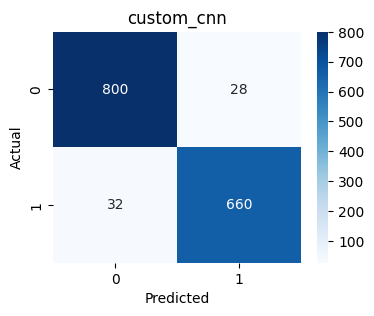

✅ Model saved to: /kaggle/working/saved_models/custom_cnn.keras
✅ Run logged offline at /kaggle/working/mlruns/custom_cnn


In [11]:
model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    verbose=1
)

# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)

## Tranining(xception)

In [12]:
MODEL_NAME = "xception"
# options:
# "custom_cnn"
# "mobilenet"
# "inception"
# "xception"

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 51s 145ms/step - accuracy: 0.7461 - loss: 0.5189 - val_accuracy: 0.8675 - val_loss: 0.3847
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8742 - loss: 0.3597 - val_accuracy: 0.8791 - val_loss: 0.3430
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8860 - loss: 0.3189 - val_accuracy: 0.8859 - val_loss: 0.3197
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8931 - loss: 0.2932 - val_accuracy: 0.8906 - val_loss: 0.3037
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8993 - loss: 0.2745 - val_accuracy: 0.8893 - val_loss: 0.2919
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9044 - loss: 0.2599 - val_accuracy: 0.8899 - val_loss: 0.2827
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.9104 - loss: 0.2480 - val_accuracy: 0.8940 - val_loss: 0.2753
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━

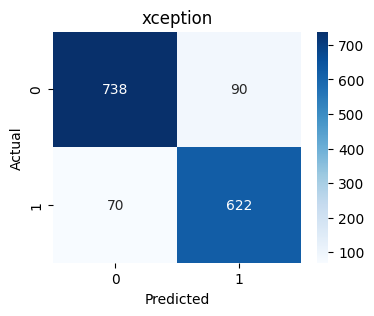

✅ Model saved to: /kaggle/working/saved_models/xception.keras
✅ Run logged offline at /kaggle/working/mlruns/xception


In [13]:
model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    verbose=1
)

# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)


## Training(inception)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.7486 - loss: 0.5262 - val_accuracy: 0.8465 - val_loss: 0.3742
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8557 - loss: 0.3651 - val_accuracy: 0.8635 - val_loss: 0.3351
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8726 - loss: 0.3276 - val_accuracy: 0.8723 - val_loss: 0.3150
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8816 - loss: 0.3042 - val_accuracy: 0.8736 - val_loss: 0.3021
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8855 - loss: 0.2874 - val_accuracy: 0.8757 - val_loss: 0.2928
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8926 - loss: 0.2744 - val_accuracy: 0.8784 - val_loss: 0.2858
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.8949 - loss: 0.2638 - val_accuracy: 0.8825 - val_loss: 0.2803
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━

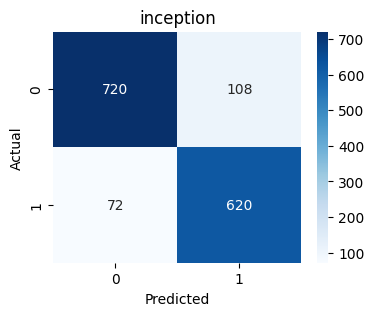

✅ Model saved to: /kaggle/working/saved_models/inception.keras
✅ Run logged offline at /kaggle/working/mlruns/inception


In [14]:
from tensorflow.keras.callbacks import EarlyStopping
MODEL_NAME = "inception"
# options:
# "custom_cnn"
# "mobilenet"
# "inception"
# "xception"

early_stop = EarlyStopping(
    monitor="val_loss",        # or "val_accuracy"
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=[early_stop], 
    verbose=1
)

# 🔹 Evaluate (now evaluates BEST model)
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save BEST model
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)



## Training(mobilenet)

/tmp/ipykernel_24/3981024702.py:24: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights="imagenet", include_top=False, input_shape=input_shape)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 23s 49ms/step - accuracy: 0.7485 - loss: 0.5147 - val_accuracy: 0.8832 - val_loss: 0.3263
Epoch 2/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8869 - loss: 0.3115 - val_accuracy: 0.9083 - val_loss: 0.2688
Epoch 3/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9034 - loss: 0.2634 - val_accuracy: 0.9171 - val_loss: 0.2409
Epoch 4/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9135 - loss: 0.2364 - val_accuracy: 0.9219 - val_loss: 0.2240
Epoch 5/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9206 - loss: 0.2182 - val_accuracy: 0.9226 - val_loss: 0.2126
Epoch 6/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9242 - loss: 0.2046 - val_accuracy: 0.9280 - val_loss: 0.2043
Epoch 7/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9295 - loss: 0.1938 - val_accuracy: 0.9334 - val_loss: 0.1980
Epoch 8/20
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms

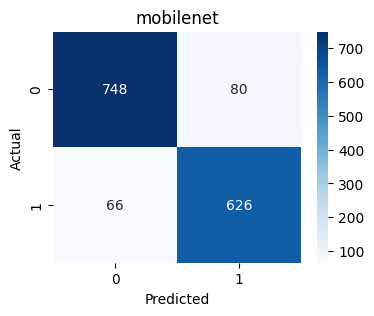

✅ Model saved to: /kaggle/working/saved_models/mobilenet.keras
✅ Run logged offline at /kaggle/working/mlruns/mobilenet


In [15]:
MODEL_NAME = "mobilenet"
# options:
# "custom_cnn"
# "mobilenet"
# "inception"
# "xception"
model = get_model(MODEL_NAME)

history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    verbose=1
)

# 🔹 Evaluate
metrics = evaluate_model(model, test, MODEL_NAME)

# 🔹 Save model for fusion
model_path = save_trained_model(model, MODEL_NAME)

# 🔹 Log offline
log_offline(
    model=model,
    model_name=MODEL_NAME,
    metrics=metrics,
    history=history,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    model_path=model_path
)


In [16]:
# 🔹 Update comparison table (optional)
df = update_comparison_table(metrics, MODEL_NAME)
df

,Model,Accuracy,F1 Micro,F1 Macro,F1 Weighted
0,mobilenet,0.903947,0.903947,0.903325,0.904019


In [17]:
import shutil

shutil.make_archive('/kaggle/working/mlruns', 'zip', '/kaggle/working/mlruns')


'/kaggle/working/mlruns.zip'

In [18]:
from IPython.display import FileLink

# Make sure path matches exactly
zip_path = "/kaggle/working/mlruns.zip"

# Display clickable download link
display(FileLink(zip_path))


/kaggle/working/mlruns.zip

In [19]:
import os

print("Exists:", os.path.exists(zip_path))
print("Size (MB):", os.path.getsize(zip_path) / (1024 * 1024))


Exists: True
Size (MB): 0.00566864013671875


In [20]:
import os

# List files in /kaggle/working/
print(os.listdir('/kaggle/working/'))


['mlruns', 'saved_models', 'mlruns.zip', '__notebook__.ipynb', 'model_comparison.csv']
